# Отчет: задание 1

*Неверо Андрей, лабораторная работа 1, 2 курс, 4 группа*

В задании требовалось написать программу, которая эффективно вычисляет обратную матрицу к матрицам почти треугольного вида (к матрицам, которые являются почти нижнетреугольными и содержат лишь по одному элементу справа от главной диагонали):

$$ \begin{bmatrix}
    X & X & 0 & 0 \\
    X & X & X & 0 \\
    X & X & X & X \\
    X & X & X & X \\
\end{bmatrix} $$

Решением данной задачи можно считать реализацию методов *CountTluDecomposition_AlmostTriangular*, *SolveSystem_AlmostTriangular*, *CountInverseMatrix_TLU_AlmostTriangular*, *CountInverseMatrix_AlmostTriangular* класса Matrix (см. соответствующий заголовочный файл).

Обработка связанных с этим заданием входных данных вынесена в отдельный класс, определенный в заголовочном файле Task1.

## Основная идея алгоритма

Обычный алгоритм нахождения обратной матрицы можно реализовать с помощью LU-разложения. Действительно, найдя LU-разложение, с его помощью можно решить $n$ систем линейных уравнений и таким образом получить все столбцы обратной матрицы. Асимптотическая сложность такого алгоритма равна $O(n^3)$. Но как можно учесть свойства заданных в данной задаче матриц?

Достаточно очевидны два подхода, которые мы и рассмотрим.

Первый подход: можно оптимизировать алгоритм LU-разложения и решения систем линейных уравнений, используя структуру матрицы. Благодаря ей, можно уменьшить асимптотику LU-разложения (с $O(n^3)$ до $O(n^2)$), а также сократить количество операций вычитания (что не повлияет на асимптотику, но улучшит производительность).

Плюс данного подхода: мы сохраняем возможность эффективного распараллеливания алгоритма нахождения обратной матрицы, что в перспективе (на более мощных компьютерах) может сильно улучшить производительность. Минус данного подхода: на слабых компьютерах (не очень мощные процессоры с 2-4 ядрами) алгоритм будет работать достаточно медленно. 

Второй подход: можно воспользоваться структурой матрицы и быстро привести ее к нижнетреугольному виду (проделав то же самое с соответствующими системами уравнений). Действительно, для этого достаточно отнять последнюю строку от предпоследней, ..., $i$-тую строку от $(i - 1)$-ой, ..., вторую строку от первой. Нахождение обратной матрицы тогда будет достаточно простым: нужно будет всего лишь проделать обратный ход метода Гаусса наоборот (сверху вниз).

Если приводить матрицу к нижнетреугольному виду для каждого столбца отдельно, мы не получим выигрыша во времени по сравнению с первым алгоритмом (скорее всего, даже ухудшим производительность). Соответственно, логично работать над всей матрицей сразу, вычитая сразу целые строки.

Заметим, что вычитание конкретной строки от всех строк ниже можно распараллелить.

Плюс данного подхода: скорее всего, компилятору удастся задействовать возможности модулей SSE и AVX процессора, которые смогут работать с матрицей в векторизованном виде и в разы ускорить операции вычитания строк. Данный эффект будет заметен даже на слабых компьютерах.

Минус данного подхода: нет никаких гарантий, что компилятор задействует вышеупомянутые оптимизации. Явно сказать ему оптимизировать конкретный цикл мы не можем (точнее, попытаться можно, но сильно пострадает переносимость решения). Соответственно, производительность решения будет зависеть от компилятора и его версии. Кроме того, реализация распараллеливания в этом случае будет сложнее, чем реализация распараллеливания в оптимизированной версии LU-алгоритма (а это негативным образом повлияет на эффективность).

В проекте реализованы оба подхода. Методы *CountTluDecomposition_AlmostTriangular*, *SolveSystem_AlmostTriangular*, *CountInverseMatrix_TLU_AlmostTriangular* отвечают за оптимизированный LU-алгоритм, метод *CountInverseMatrix_AlmostTriangular* - за специальный алгоритм (приводящий матрицу к треугольному виду).

## Пункт 1

Найденная обратная матрица выглядит следующим образом (точность до 5 знаков после точки):

$$ X = \begin{bmatrix}
        4.6667 & -2.33333 & -1.66667 & 3.33333 \\
        15 & -7 & -5 & 10 \\
        -6 & 3 & 2 & -4 \\
        -22 & 10 & 7 & -15
\end{bmatrix} $$

Абсолютно точное решение получить не удалось в связи с делением на тройку, но и полученный результат очень неплох (погрешность минимальна). Точность до пяти знаков после запятой обеспечивает как тип *long double*, так и обычный *float*.

## Пункт 2

Заданная матрица является вырожденной: у нее линейно зависимы как минимум первые две строки. Следовательно, нахождение обратной матрицы не представляется возможным.

## Пункт 3

Выясним, какой алгоритм эффективнее всего находит обратную матрицу к нашей матрице специального вида.

Проанализируем время работы обычного алгоритма, основанного на LU-разложении, оптимизированного алгоритма, основанного на LU-разложении, а также специального алгоритма для рассматриваемых матриц, на разных типах вещественных чисел. Для этого воспользуемся функцией *RandomInput* в классе *Task1*.

Данная функция генерирует случайную почти треугольную матрицу определенного размера (значения в матрице - возмущенные от $1$ до $5000$), после чего подсчитывает время работы обычного и оптимизированного алгоритма по нахождению обратной матрицы для трех типов - *float*, *double* и *long double*.

Данная функция запускалась для матриц размером $n = 150k$ до $2100$. Полученные результаты для типов *float*, *double* и *long double* можно увидеть ниже. График красного цвета - график работы обычного алгоритма, основанного на LU-разложении, синего цвета - оптимизированного алгоритма, основанного на LU-разложении, зеленого цвета - специального алгоритма. Величины на оси слева - микросекунды.

Напомним, при тестировании использовался компьютер с 2-ядерным процессором Intel. Все тестируемые алгоритмы работали в многопоточном режиме.

In [1]:
from data import task1
import matplotlib
%matplotlib inline

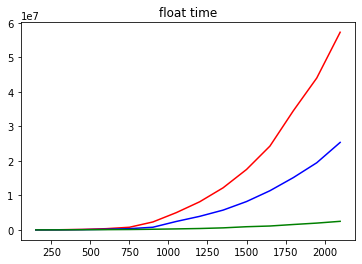

In [2]:
bins = [i for i in range(150, 2101, 150)]
matplotlib.pyplot.title("float time")
matplotlib.pyplot.plot(bins, task1.float_tlu_time, 'r',
                       bins, task1.float_optimized_tlu_time, 'b',
                       bins, task1.float_triangular_time, 'g')
matplotlib.pyplot.show()

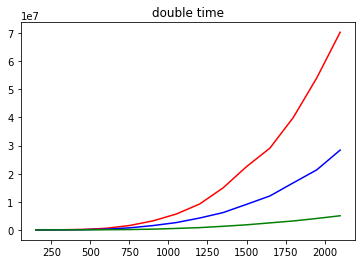

In [3]:
matplotlib.pyplot.title("double time")
matplotlib.pyplot.plot(bins, task1.double_tlu_time, 'r',
                       bins, task1.double_optimized_tlu_time, 'b',
                       bins, task1.double_triangular_time, 'g')
matplotlib.pyplot.show()

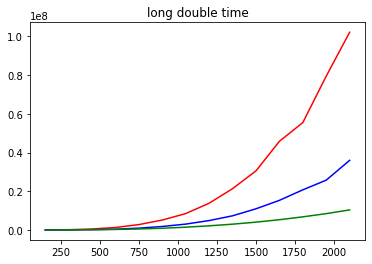

In [4]:
matplotlib.pyplot.title("long double time")
matplotlib.pyplot.plot(bins, task1.long_double_tlu_time, 'r',
                       bins, task1.long_double_optimized_tlu_time, 'b',
                       bins, task1.long_double_triangular_time, 'g')
matplotlib.pyplot.show()

Как видно, уже на матрицах размером $\approx 750$ обычный алгоритм, основанный на LU-разложении, начинает безнадежно отставать от оптимизированного, а оптимизированный - от специального (приводящего матрицу к треугольному виду).

Сравним для интереса время работы оптимизированного алгоритма, основанного на LU-разложении, а также специального алгоритма, на разных типах вещественных чисел. Желтым цветом обозначен график *long double*, черным - *double*, зеленым - *float*.

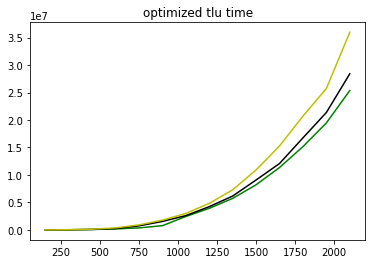

In [5]:
matplotlib.pyplot.title("optimized tlu time")
matplotlib.pyplot.plot(bins, task1.float_optimized_tlu_time, 'g',
                       bins, task1.double_optimized_tlu_time, 'k',
                       bins, task1.long_double_optimized_tlu_time, 'y')
matplotlib.pyplot.show()

Нетрудно видеть, что хотя небольшая разница между типами присутствует, в общем можно утверждать, что выбранный тип вещественных чисел не оказывает заметного влияния на скорость работы алгоритма. Это и логично: быстродействие алгоритма основано на многопоточности, никакие специфические возможности модулей процессора (вроде векторизации) им не используются.

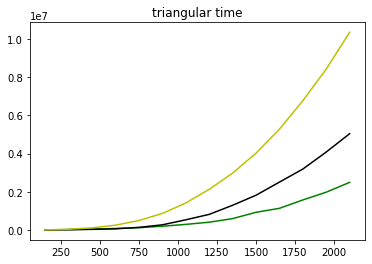

In [6]:
matplotlib.pyplot.title("triangular time")
matplotlib.pyplot.plot(bins, task1.float_triangular_time, 'g',
                       bins, task1.double_triangular_time, 'k',
                       bins, task1.long_double_triangular_time, 'y')
matplotlib.pyplot.show()

Как можно заметить, производительность специального алгоритма, быстродействие которого зависит в том числе от эффективности векторизации, сильно зависит от типов, с которыми он работает. Работа с *float* ожидаемо оказалась примерно в два раза быстрее, чем работа с *double* (как можно заметить, *double* занимает ровно в два раза больше места, так что векторизация операций с ним ровно в два раза менее эффективна). За обработку *long double* отвечает математический сопроцессор, а он, как известно, не поддерживает эффективную векторизацию. Поэтому еще большее замедление алгоритма при работе с *long double* не вызывает вопросов.

Сравним теперь время работы оптимизированного алгоритма, основанного на LU-разложении, в однопоточном и многопоточном режиме. Красный график отвечает за однопоточный режим, синий - многопоточный. Использовался тип *double*, размеры матриц - $n = 500k$ до $3000$.

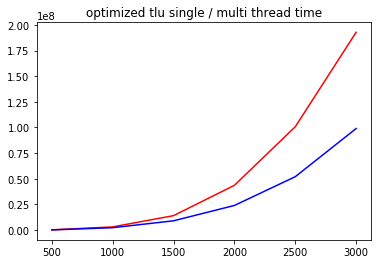

In [7]:
bins = [i for i in range(500, 3001, 500)]
matplotlib.pyplot.title("optimized tlu single / multi thread time")
matplotlib.pyplot.plot(bins, task1.single_thread_optimized_tlu_time, 'r',
                       bins, task1.multi_thread_optimized_tlu_time, 'b')
matplotlib.pyplot.show()

Чем больше размер матрицы, тем больше разница между однопоточным и многопоточным вариантами алгоритма. На матрицах размером $n = 3000$ однопоточный алгоритм примерно в два раза медленнее многопоточного (напомним, при тестировании использовался 2-ядерный процессор). Очевидно, что многопоточность положительным образом влияет на производительность данного алгоритма, и если использовать еще больше ядер, скорость работы программы еще больше увеличится.

Сравним однопоточную и многопоточную версию специального алгоритма, приводящего матрицу к треугольному виду. Первый выделен красным цветом, второй - синим.

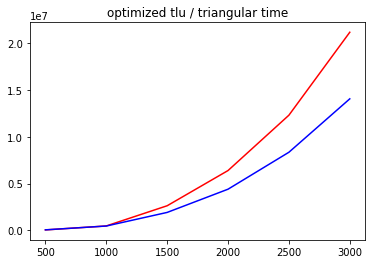

In [8]:
matplotlib.pyplot.title("optimized tlu / triangular time")
matplotlib.pyplot.plot(bins, task1.single_thread_triangular_time, 'r',
                       bins, task1.multi_thread_triangular_time, 'b')
matplotlib.pyplot.show()

Хотя различие между временем работы алгоритмов не такое разительное, как в случае с LU-алгоритмом, оно все же заметно. При наличии необходимого аппаратного обеспечения можно протестировать алгоритм на процессорах с большим количеством ядер (к сожалению, сделать это в рамках данной лабораторной работы я не могу в связи с отсутствием необходимого аппаратного обеспечения).

## Размер матрицы, обрабатываемой за минуту

Условие задачи требует указать, матрицу какого размера написанный алгоритм способен обработать за одну минуту. На моем компьютере многопоточная версия специального алгоритма за минуту справилась с матрицами следующих размеров:

* Матрица размером $n \approx 6200$ типа *float*
* Матрица размером $n \approx 5000$ типа *double*
* Матрица размером $n \approx 3900$ типа *long double*